In [304]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from pathlib import Path
from utility import CoxPHLoss
from sklearn.preprocessing import StandardScaler
from data_loader import load_veterans_ds, load_cancer_ds, load_aids_ds, load_nhanes_ds # datasets
from data_loader import prepare_veterans_ds, prepare_cancer_ds, \
                        prepare_aids_ds, prepare_nhanes_ds # prepare funcs
from sksurv.linear_model.coxph import BreslowEstimator
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
from sklearn.model_selection import train_test_split
from model_builder import make_nobay_model

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_veterans_ds()
t_train, t_valid, t_test, e_train, e_valid, e_test  = prepare_veterans_ds(y_train, y_valid, y_test)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Create model instance
model = make_nobay_model(input_shape=X_train.shape[1:], output_dim=2)

# Restore the weights
curr_dir = os.getcwd()
root_dir = Path(curr_dir).absolute().parent
model.load_weights(f'{root_dir}/models/nobay/')

optimizer = tf.keras.optimizers.Adam()
loss_fn = CoxPHLoss()

model.compile(loss=loss_fn, optimizer=optimizer)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [305]:
# Train the Brewslow estimator
train_predictions = model.predict(X_train, verbose=0).reshape(-1)
breslow = BreslowEstimator().fit(train_predictions, e_train, t_train)

# Sample 5 samples 10 times from the Gaussian posterior
runs = 10
n_test_samples = 5
test_sample = train_test_split(X_test, y_test, e_test, t_test,
                               test_size=n_test_samples, stratify=e_test,
                               random_state=0)
x_sample, y_sample, event_sample, time_sample = test_sample[1::2]
model_nobay = np.zeros((runs, len(x_sample)))
for i in range(0, runs):
    model_nobay[i,:] = np.reshape(model.predict(x_sample, verbose=0), len(x_sample))
    
# Predict the surv func using Breslow 10 times to estimate variance
event_times = breslow.get_survival_function(model_nobay[0])[0].x
breslow_surv_times = np.zeros((len(x_sample), runs, len(event_times)))
for i in range(0, runs):
    surv_fns = breslow.get_survival_function(model_nobay[i,:])
    for j, surv_fn in enumerate(surv_fns):
        breslow_surv_times[j,i,:] = surv_fn.y
        
# Predict the hazard func using Breslow 10 times to estimate variance
breslow_hazard_times = np.zeros((len(x_sample), runs, len(event_times)))
for i in range(0, runs):
    hazard_fns = breslow.get_cumulative_hazard_function(model_nobay[i,:])
    for j, hazard_fn in enumerate(hazard_fns):
        breslow_hazard_times[j,i,:] = hazard_fn.y

In [306]:
breslow_surv_times.shape

(5, 10, 85)

In [307]:
breslow_hazard_times.shape

(5, 10, 85)

In [325]:
n_samples = breslow_surv_times.shape[1]

obs_1_surv_times = breslow_surv_times[0,:,:]
obs_1_hazard_times = breslow_hazard_times[0,:,:]

ci_surv = 1.96 * np.std(obs_1_surv_times, axis=0) / np.sqrt(n_samples) # 95% CI
ci_hazard = 1.96 * np.std(obs_1_hazard_times, axis=0) / np.sqrt(n_samples) # 95% CI

mean_surv_times = np.mean(obs_1_surv_times, axis=0)
mean_hazard_times = np.mean(obs_1_surv_times, axis=0)

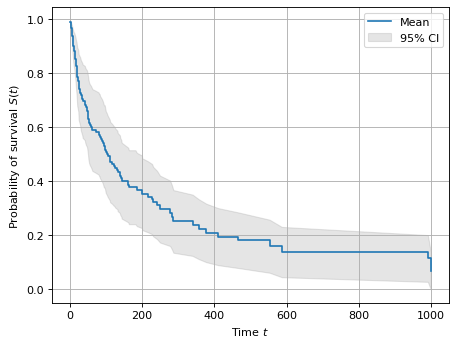

In [326]:
# Plot surv funcs with mean and CI
plt.figure(dpi=80)
plt.step(event_times, mean_surv_times, where="post", label="Mean")
plt.fill_between(event_times, mean_surv_times-ci_surv, mean_surv_times+ci_surv,
                 color='gray', alpha=0.2, label="95% CI")
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$")
plt.legend()
plt.grid(True)
plt.show()

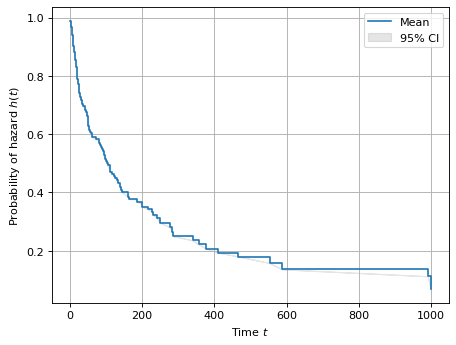

In [327]:
# Plot hazard funcs with mean and CI
styles = ('-', '--')
plt.figure(dpi=80)
plt.step(event_times, mean_hazard_times, where="post", label="Mean")
plt.fill_between(event_times, mean_hazard_times-ci_hazard,
                 mean_hazard_times+ci_hazard,
                 color='gray', alpha=0.2, label="95% CI")
plt.ylabel("Probability of hazard $h(t)$")
plt.xlabel("Time $t$")
plt.grid(True)
plt.legend()
plt.show()

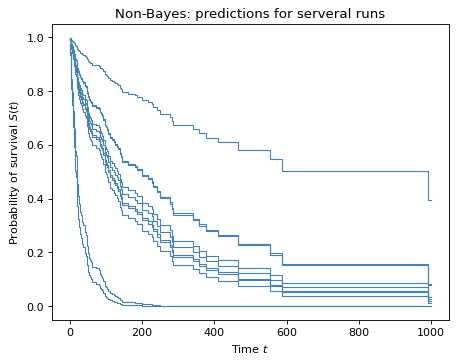

In [328]:
# Make n realizations of the surv curve for obs 1
def make_plot_runs(preds, alpha_data=1):
  for i in range(0, preds.shape[0]):
    plt.step(event_times, preds[i], color="steelblue",
             linewidth=1, alpha=alpha_data)

plt.figure(dpi=80)
make_plot_runs(obs_1_surv_times)
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$")
plt.title('Non-Bayes: predictions for serveral runs')
plt.show()

In [382]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

mean, lower, upper = [],[],[]
ci = 0.95
for i in range(len(event_times)):
    m, ml, mu = mean_confidence_interval(obs_1_surv_times[:,i], ci)
    mean.append(m)
    lower.append(ml)
    upper.append(mu)


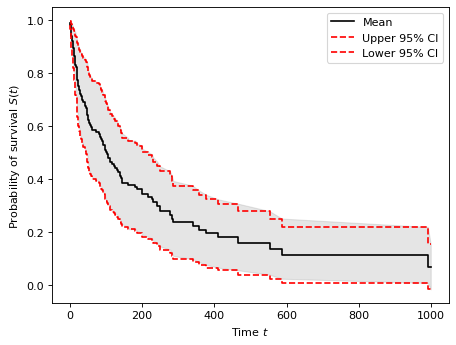

In [413]:
plt.figure(dpi=80)
plt.step(event_times, mean, color="black", label='Mean')
plt.step(event_times, upper, color="red", linewidth=1.5, linestyle="--", label='Upper 95% CI')
plt.step(event_times, lower, color="red", linewidth=1.5, linestyle="--", label='Lower 95% CI')
plt.fill_between(event_times, upper, lower, color="gray", alpha=0.2)
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$")
plt.legend()